# Data Wrangling & Exploratory Analysis

## Imports and Data Load

This notebook will encompass both our wrangling and exploration of the data. I begin with the notion of a pretty clean dataset, but that's an assumption never to be made. Let's take a look, starting with our imports for these efforts.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

Temperature data will be sourced by the National Oceanic and Atmospheric Administration (NOAA) as a CSV file downloaded through climate.gov. The weekly deaths data is from a CSV sourced by the Oregon Health Authority Center.

In [2]:
temps = pd.read_csv('daily_temps.csv')
deaths = pd.read_csv('weekly_deaths.csv')

## Data Definition and EDA:  'temps' data

Let's begin with some basic methods on the Pandas dataframes. I'll continue with wrangling and exploring the temperature dataset before moving on to the deaths data. Currently, the temperature data will only serve as a reference to the heatwave timing in which we intend to estimate excess deaths.

In [3]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324 entries, 0 to 12323
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          670 non-null    object 
 1   NAME             670 non-null    object 
 2   LATITUDE         670 non-null    float64
 3   LONGITUDE        670 non-null    float64
 4   ELEVATION        670 non-null    float64
 5   DATE             670 non-null    object 
 6   TAVG             0 non-null      float64
 7   TAVG_ATTRIBUTES  0 non-null      float64
 8   TMAX             670 non-null    float64
 9   TMAX_ATTRIBUTES  670 non-null    object 
 10  TMIN             670 non-null    float64
 11  TMIN_ATTRIBUTES  670 non-null    object 
 12  TOBS             663 non-null    float64
 13  TOBS_ATTRIBUTES  663 non-null    object 
dtypes: float64(8), object(6)
memory usage: 1.3+ MB


In [4]:
temps.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES
0,USC00356749,"PORTLAND KGW TV, OR US",45.5181,-122.6894,48.5,1/1/2020,NaN,NaN,54.0,",,7",46.0,",,7",46.0,",,7,2200"
1,USC00356749,"PORTLAND KGW TV, OR US",45.5181,-122.6894,48.5,1/2/2020,NaN,NaN,54.0,",,7",42.0,",,7",51.0,",,7,2200"
2,USC00356749,"PORTLAND KGW TV, OR US",45.5181,-122.6894,48.5,1/3/2020,NaN,NaN,61.0,",,7",42.0,",,7",53.0,",,7,2200"
3,USC00356749,"PORTLAND KGW TV, OR US",45.5181,-122.6894,48.5,1/4/2020,NaN,NaN,53.0,",,7",41.0,",,7",43.0,",,7,2200"
4,USC00356749,"PORTLAND KGW TV, OR US",45.5181,-122.6894,48.5,1/5/2020,NaN,NaN,47.0,",,7",41.0,",,7",44.0,",,7,2200"


In [5]:
#What are the attributes columns? 
temps['TMAX_ATTRIBUTES'].value_counts()

,,7    639
,,H     31
Name: TMAX_ATTRIBUTES, dtype: int64

In [6]:
temps['TMIN_ATTRIBUTES'].value_counts()

,,7    639
,,H     31
Name: TMIN_ATTRIBUTES, dtype: int64

The attributes columns look pretty meaningless, so I'm going to get rid of them and focus only on the temp mins and maxes.

In [7]:
#Checking to see if there is any variation in the location data.
print(temps['LATITUDE'].value_counts())
print(temps['LONGITUDE'].value_counts())

45.5181    670
Name: LATITUDE, dtype: int64
-122.6894    670
Name: LONGITUDE, dtype: int64


All of our temperature data is for Portland, the most populated city in Oregon. The weekly death data is for all of Oregon. There was some death data available by county, but it did not have reference to the COVID deaths. I believe it will be valuable to have COVID deaths so we can remove them from the data in order to better estimate excess deaths caused by the heatwave, without contribution from COVID.

In [8]:
#All of this data is for one location - Portland, so I don't need the longitude and latitude columns, or the 
#elevation column. I'm going to focus on only the date column and the TMAX and TMIN values.
temps = temps[['DATE', 'TMAX', 'TMIN']]

In [9]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324 entries, 0 to 12323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    670 non-null    object 
 1   TMAX    670 non-null    float64
 2   TMIN    670 non-null    float64
dtypes: float64(2), object(1)
memory usage: 289.0+ KB


In [10]:
#Changing date to datetime format
temps['DATE'] = pd.to_datetime(temps['DATE'])

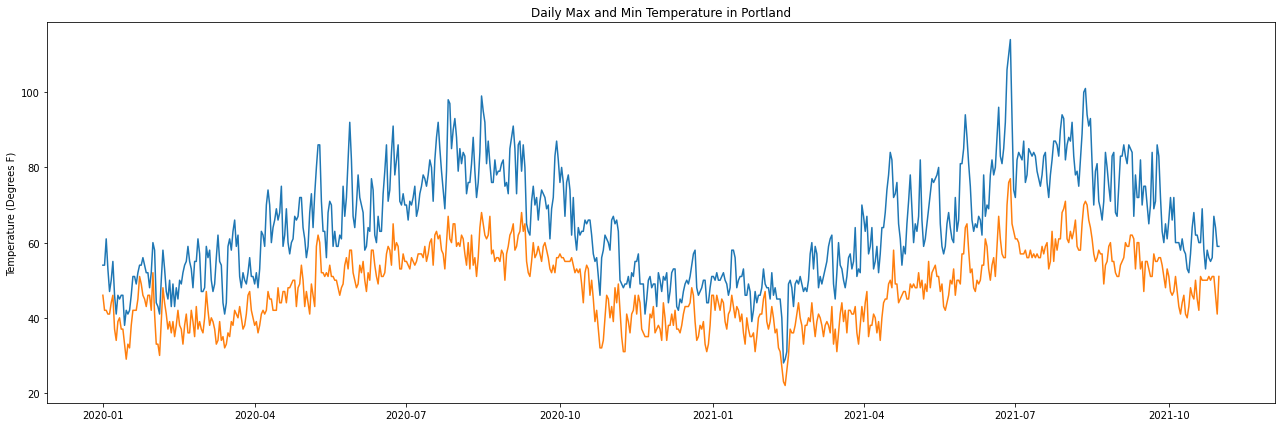

In [11]:
#Let's plot the data as a time series to get our first visualization and see if there are any obvious outliers.
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(temps['DATE'], temps['TMAX'])
_ = plt.plot(temps['DATE'], temps['TMIN'])
_ = plt.ylabel('Temperature (Degrees F)')
_ = plt.title('Daily Max and Min Temperature in Portland')

It's really easy to see the temperature spike in late June/early July from this graph. This is the temp spike that I will
be focusing on. I'm going to find the dates for this temp spike and put a range of the graph to really highlight it.

NOTE: There appears to be a second heat wave sometime around August. I want to remember this when looking at the death data.

In [12]:
#Identifying the heatwave dates for reference and visualization
high_temp = 103
high_temp_days = temps.loc[temps['TMAX'] > high_temp, 'DATE'].tolist()
high_temp_days

[Timestamp('2021-06-26 00:00:00'),
 Timestamp('2021-06-27 00:00:00'),
 Timestamp('2021-06-28 00:00:00')]

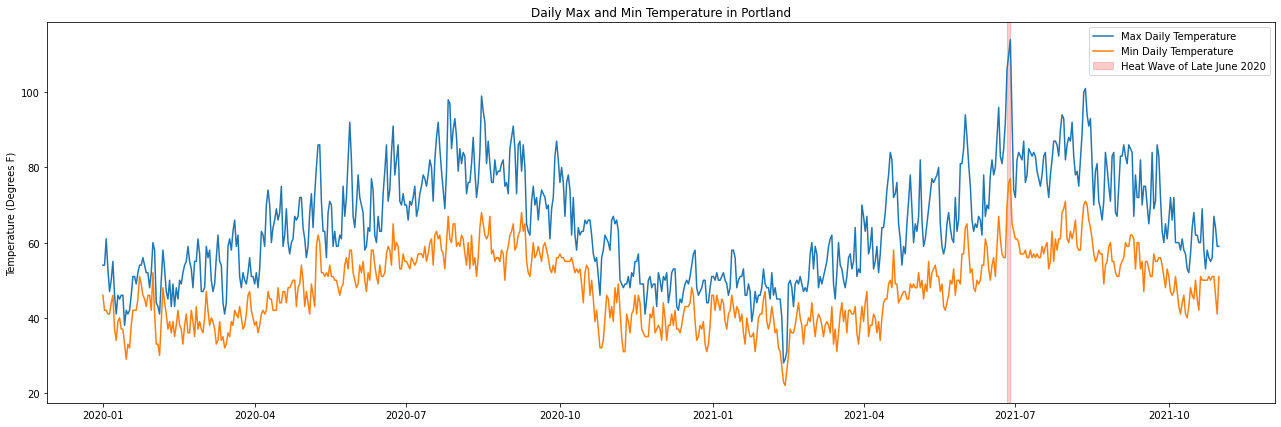

In [13]:
#Adding a visual indicator to the same plot as above for reference of the heat wave
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(temps['DATE'], temps['TMAX'], label = 'Max Daily Temperature')
_ = plt.plot(temps['DATE'], temps['TMIN'], label = 'Min Daily Temperature')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Temperature (Degrees F)')
_ = plt.title('Daily Max and Min Temperature in Portland')
_ = plt.legend()

I want to estimate how many deaths were due to this spike in temperature. I'm going to pull in the deaths data and check it out and then I will come back to the temps data as needed.

## Data Definition and EDA: 'deaths' data

In [14]:
deaths.head()

,Week of Date,Week start,Week end,2020-21 deaths,Average 2017-2019,Excess deaths (over 3-yr average),Average 2015-2019,Excess deaths (over 5-yr average),COVID-19 deaths
0,Total,Total,Total,"77,078","67,276","9,802","66,459","10,619","4,518"
1,Week starting 10/24/2021,10/24/2021,10/30/2021,879,685,194,676,203,64
2,Week starting 10/17/2021,10/17/2021,10/23/2021,961,721,240,688,273,73
3,Week starting 10/10/2021,10/10/2021,10/16/2021,954,699,255,686,268,81
4,Week starting 10/03/2021,10/3/2021,10/9/2021,977,695,282,685,292,139


In [15]:
deaths.tail()

,Week of Date,Week start,Week end,2020-21 deaths,Average 2017-2019,Excess deaths (over 3-yr average),Average 2015-2019,Excess deaths (over 5-yr average),COVID-19 deaths
92,Week starting 1/26/2020,1/26/2020,2/1/2020,719,724,-5,724,-5,0
93,Week starting 1/19/2020,1/19/2020,1/25/2020,751,781,-30,760,-9,0
94,Week starting 1/12/2020,1/12/2020,1/18/2020,776,800,-24,765,11,0
95,Week starting 1/05/2020,1/5/2020,1/11/2020,764,845,-81,796,-32,0
96,Week starting 12/29/2019,1/1/2020,1/4/2020,403,455,-52,445,-42,0


Interestingly, we already have the excess deaths compared to 3 and 5 year averages but not the excess deaths given the trend for 2020-21 weekly deaths. I want to estimate the excess deaths for the week of record setting heat by forecasting the expected deaths using early 2020-21 historicals. We are seeing excess deaths beyond COVID-19 deaths, suspected to be indirectly related to COVID, and will use this to estimate the deaths beyond average excess for 2020-21.

The deaths data is weekly instead of daily (like the temps data). I will consider calculating the average TMAX and TMIN for each week if necessary. My current approach is to use the temperature data just for reference and as a means to EDA. The deaths data has columns representing 2020-21, plus average and excess deaths for 3 and 5 year ranges. With my current approach to estimate excess deaths based on variance to a forecast, all I need is the 2020-21 deaths and the COVID-19 deaths (so I can eliminate them from my dataset). 

That said, let's take a look at some plots that include the 3 and 5 year references for average and excess deaths.

In [16]:
#First I have to get rid of the first row which shows some aggregated numbers
deaths = deaths.iloc[1:,:]

In [17]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 1 to 96
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Week of Date                       96 non-null     object
 1   Week start                         96 non-null     object
 2   Week end                           96 non-null     object
 3   2020-21 deaths                     96 non-null     object
 4   Average 2017-2019                  96 non-null     object
 5   Excess deaths (over 3-yr average)  96 non-null     object
 6   Average 2015-2019                  96 non-null     object
 7   Excess deaths (over 5-yr average)  96 non-null     object
 8   COVID-19 deaths                    96 non-null     object
dtypes: object(9)
memory usage: 6.9+ KB


In [18]:
#I have no null entires, but all of the dtypes are objects. I'll have to fix that now.
deaths['Week start'] = pd.to_datetime(deaths['Week start'])
deaths['Week end'] = pd.to_datetime(deaths['Week end'])

#I have to change all of the columns other than the first three to numbers. First I'll make a list of the column names
cols = list(deaths)

#Getting rid of first three
cols = cols[3:]
print(cols)

['2020-21 deaths', 'Average 2017-2019', 'Excess deaths (over 3-yr average)', 'Average 2015-2019', 'Excess deaths (over 5-yr average)', 'COVID-19 deaths']


In [19]:
#First removing all of the commas in the number strings, then changing all the death numbers to integers
for col in cols:
    deaths[col] = deaths[col].replace(',', '', regex = True)
    deaths[col] = deaths[col].astype(int)

In [20]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 1 to 96
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Week of Date                       96 non-null     object        
 1   Week start                         96 non-null     datetime64[ns]
 2   Week end                           96 non-null     datetime64[ns]
 3   2020-21 deaths                     96 non-null     int32         
 4   Average 2017-2019                  96 non-null     int32         
 5   Excess deaths (over 3-yr average)  96 non-null     int32         
 6   Average 2015-2019                  96 non-null     int32         
 7   Excess deaths (over 5-yr average)  96 non-null     int32         
 8   COVID-19 deaths                    96 non-null     int32         
dtypes: datetime64[ns](2), int32(6), object(1)
memory usage: 4.6+ KB


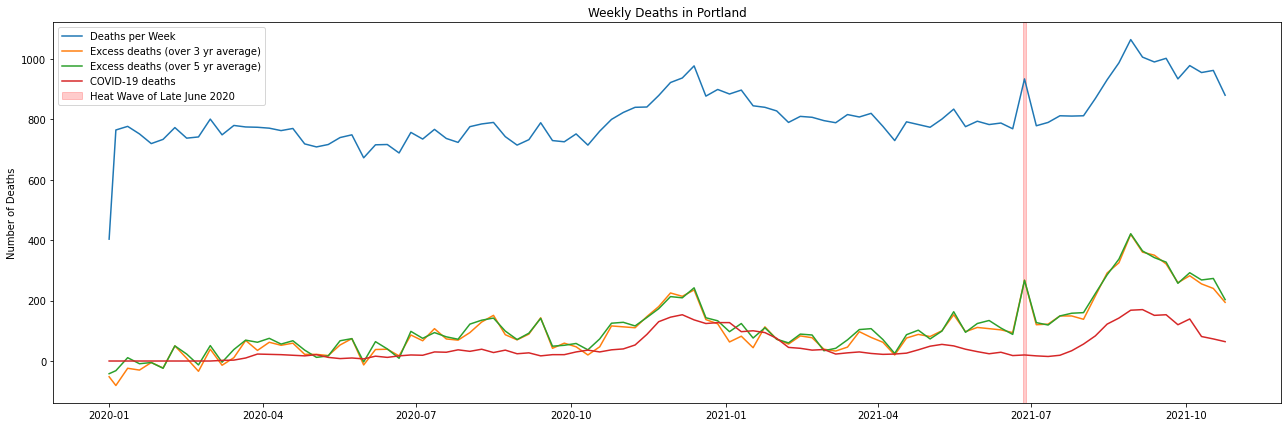

In [21]:
#Now that I have all of the data in the right format, I can start to plot.
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['2020-21 deaths'], label = 'Deaths per Week')
_ = plt.plot(deaths['Week start'], deaths['Excess deaths (over 3-yr average)'], label = 'Excess deaths (over 3 yr average)')
_ = plt.plot(deaths['Week start'], deaths['Excess deaths (over 5-yr average)'], label = 'Excess deaths (over 5 yr average)')
_ = plt.plot(deaths['Week start'], deaths['COVID-19 deaths'], label = 'COVID-19 deaths')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

Wow! There is a CLEAR spike in deaths during the heat wave. We can also see how the excess deaths accounts for an increase at this time. It's interesting to see a similar pattern between deaths per week and excess deaths, beyond the heatwave but with a greater magnitude than COVID deaths. This suggests that COVID might be causing excess deaths beyond the scope of what is considered a COVID death. Knowing how this disease works, it's fair to say that a number of complications related to COVID appear to be causing deaths that aren't considered COVID deaths.

If this is the case, we sould see the 2020-21 deaths per week trend with a greater magnitude than the trends for averages. We'll need to remove COVID deaths from the 2020-21 deaths per week for a more clear picture. Before we do that, let's take a look at the same trends as above but with averages instead of excess for the 3 and 5 year ranges.

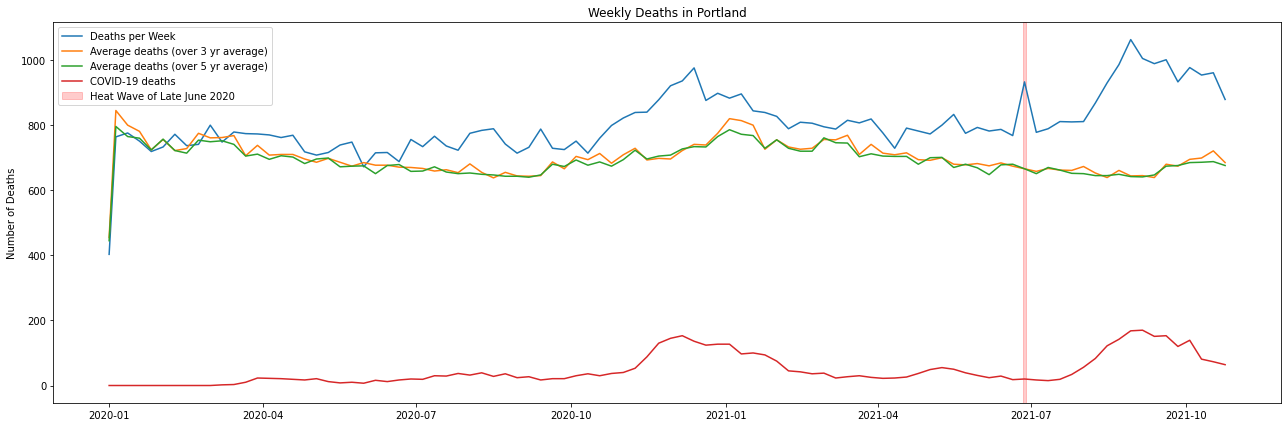

In [22]:
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['2020-21 deaths'], label = 'Deaths per Week')
_ = plt.plot(deaths['Week start'], deaths['Average 2017-2019'], label = 'Average deaths (over 3 yr average)')
_ = plt.plot(deaths['Week start'], deaths['Average 2015-2019'], label = 'Average deaths (over 5 yr average)')
_ = plt.plot(deaths['Week start'], deaths['COVID-19 deaths'], label = 'COVID-19 deaths')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

It is very obvious that 2020-21 death rates are exceeding 3 and 5 year averages. Given the ongoing pandameic, this isn't a surprise, but the trend appears to be more than just from COVID deaths. Let's remove COVID deaths from the 2020-21 weekly deaths and plot the results. We'll keep the averages in our plot as well. I'm also going to clean the data up a bit more by moving the dates of interest back a week. It looks like we don't have a full week of data for the first week.

In [23]:
deaths['Non-Covid deaths per Week'] = deaths['2020-21 deaths'] - deaths['COVID-19 deaths']
print(min(deaths['Week start']))

2020-01-01 00:00:00


In [24]:
deaths = deaths.loc[deaths['Week start'] > pd.to_datetime('2020-01-01')]

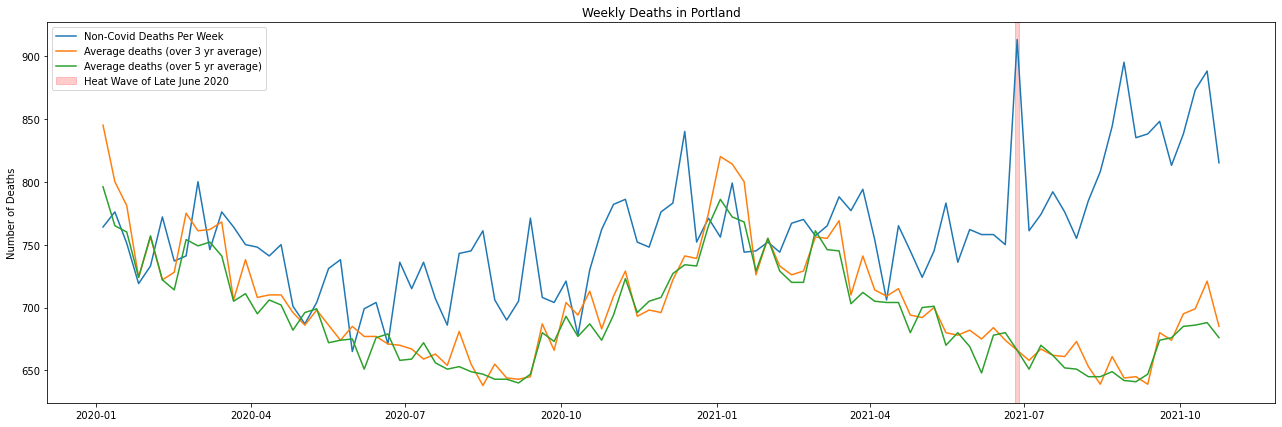

In [25]:
#Now we can plot the Non-Covid deaths against our averages
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['Non-Covid deaths per Week'], label = 'Non-Covid Deaths Per Week')
_ = plt.plot(deaths['Week start'], deaths['Average 2017-2019'], label = 'Average deaths (over 3 yr average)')
_ = plt.plot(deaths['Week start'], deaths['Average 2015-2019'], label = 'Average deaths (over 5 yr average)')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

There it is again! The weekly deaths (excluding Covid!) dating back to January, 2020 are noticably greater than the average deaths over the last 5 years. This presents an interesting opportunity for our project. The original intent was to estimate excess deaths due to the June '21 heatdome. We can now also consider estimates for pandemic related extra deaths that weren't directly due to Covid. I think in order to do so, we'll have to use our averages for the forecast rather than 2020-21. When using the 2020-21 deaths to forecast, I now know that excess deaths are involved. This shouldn't be a problem considering the excess deaths have continued and the heatwave corresponds with a significant spike.

Getting back to our original focus, let's take a look at a plot of just non-covid deaths.

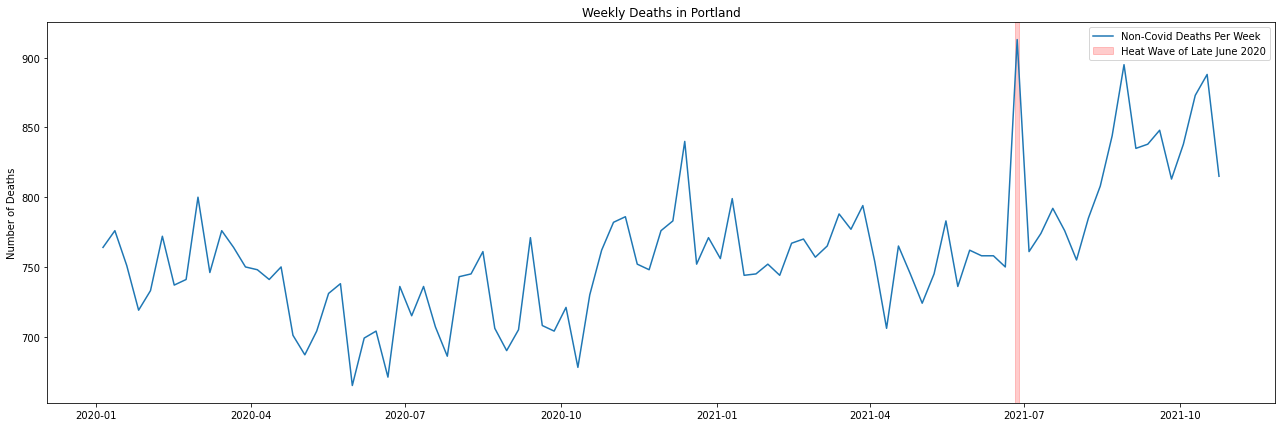

In [26]:
#Now that I have all of the data in the right format, I can start to plot.
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['Non-Covid deaths per Week'], label = 'Non-Covid Deaths Per Week')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

The death spike during the week of the heat wave is really obvious. I recall the second heat wave we saw earlier, and it
looks like it might line up with the death spike that happened after the first. I will pull the dates for the second heat wave and plot them with the deaths per week to see if they align.

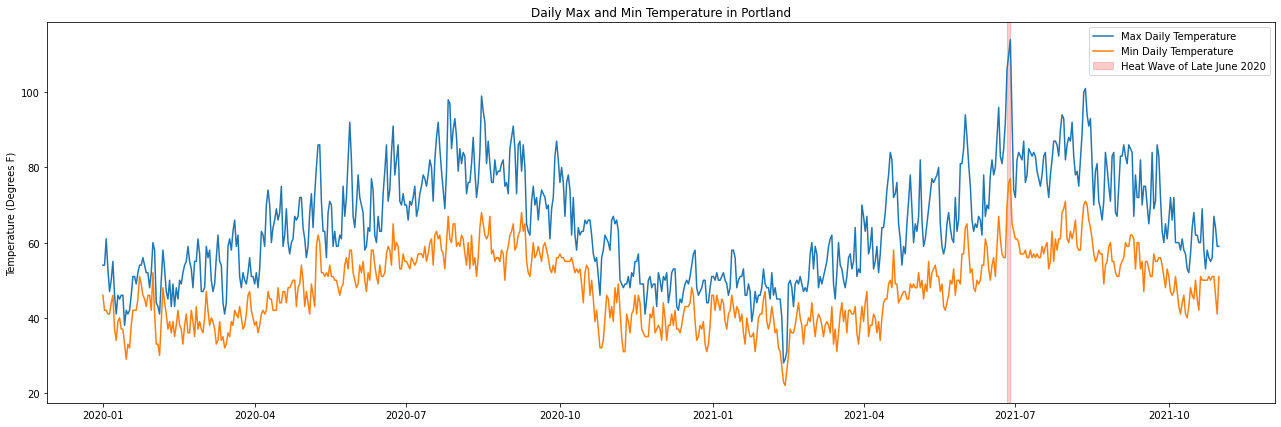

In [27]:
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(temps['DATE'], temps['TMAX'], label = 'Max Daily Temperature')
_ = plt.plot(temps['DATE'], temps['TMIN'], label = 'Min Daily Temperature')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Temperature (Degrees F)')
_ = plt.title('Daily Max and Min Temperature in Portland')
_ = plt.legend()

The second heat wave wasn't as hot so I'll lower my threshold to identify the dates.

In [28]:
high_temp = 99
high_temp_days = temps.loc[temps['TMAX'] > high_temp, 'DATE'].tolist()
high_temp_days

[Timestamp('2021-06-26 00:00:00'),
 Timestamp('2021-06-27 00:00:00'),
 Timestamp('2021-06-28 00:00:00'),
 Timestamp('2021-08-11 00:00:00'),
 Timestamp('2021-08-12 00:00:00')]

We can see the second heat wave occurs around 8/11-12. I'll define the two heat waves, check the dates, then plot the temps.

In [29]:
cutoff_between_heatwaves = '2021-08-10'
first_heat_wave = list(filter(lambda day: day < pd.to_datetime(cutoff_between_heatwaves), high_temp_days))
second_heat_wave = list(filter(lambda day: day > pd.to_datetime(cutoff_between_heatwaves), high_temp_days))

In [30]:
first_heat_wave

[Timestamp('2021-06-26 00:00:00'),
 Timestamp('2021-06-27 00:00:00'),
 Timestamp('2021-06-28 00:00:00')]

In [31]:
second_heat_wave

[Timestamp('2021-08-11 00:00:00'), Timestamp('2021-08-12 00:00:00')]

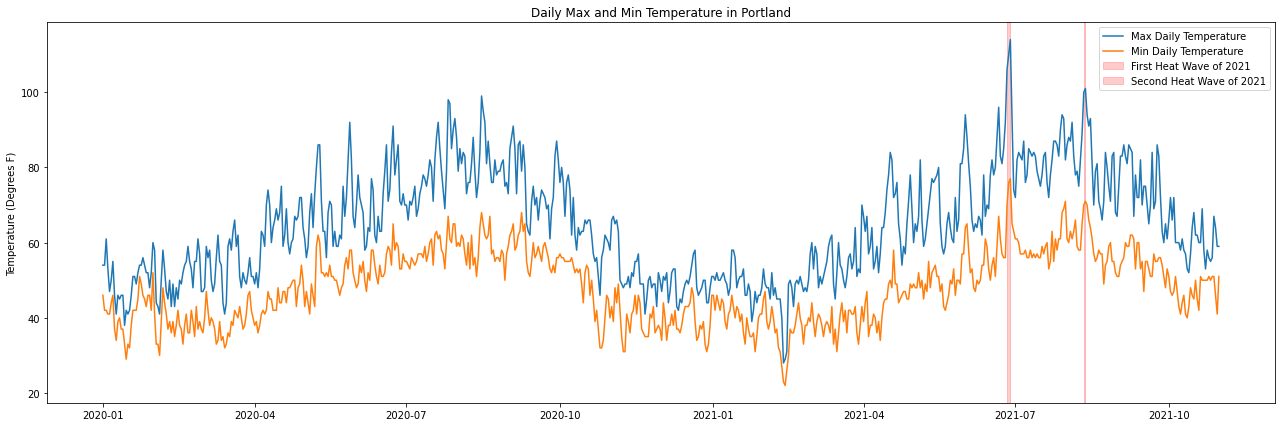

In [32]:
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(temps['DATE'], temps['TMAX'], label = 'Max Daily Temperature')
_ = plt.plot(temps['DATE'], temps['TMIN'], label = 'Min Daily Temperature')
_ = plt.axvspan(min(first_heat_wave), max(first_heat_wave), alpha = 0.2, color = 'red', label = 'First Heat Wave of 2021')
_ = plt.axvspan(min(second_heat_wave), max(second_heat_wave), alpha = 0.2, color = 'red', label = 'Second Heat Wave of 2021')
_ = plt.ylabel('Temperature (Degrees F)')
_ = plt.title('Daily Max and Min Temperature in Portland')
_ = plt.legend()

Now that I have the second heat wave identified and confirmed, let's plot the heat wave verticals on the plot of non-covid weekly deaths per week.

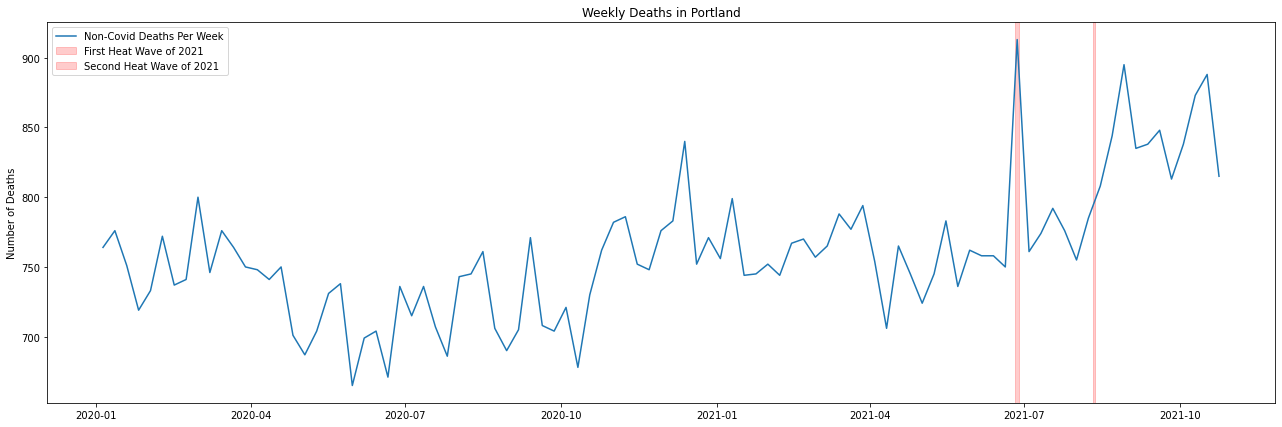

In [33]:
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['Non-Covid deaths per Week'], label = 'Non-Covid Deaths Per Week')
_ = plt.axvspan(min(first_heat_wave), max(first_heat_wave), alpha = 0.2, color = 'red', label = 'First Heat Wave of 2021')
_ = plt.axvspan(min(second_heat_wave), max(second_heat_wave), alpha = 0.2, color = 'red', label = 'Second Heat Wave of 2021')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

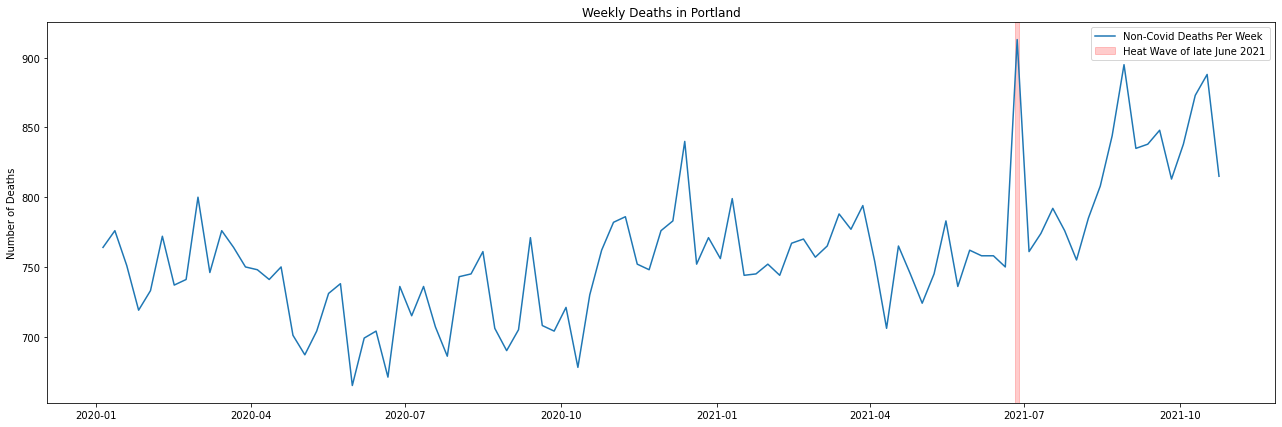

In [34]:
#Turns out the second heat wave doesn't line up with the second death spike. We will just focus on the first heat wave.
_ = plt.figure(figsize = (22, 7))
_ = plt.plot(deaths['Week start'], deaths['Non-Covid deaths per Week'], label = 'Non-Covid Deaths Per Week')
_ = plt.axvspan(min(first_heat_wave), max(first_heat_wave), alpha = 0.2, color = 'red', label = 'Heat Wave of late June 2021')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

## Summary

I started this notebook by loading two CSV files sourced by a couple of government agencies. We were fortunate to receive fairly clean and complete data, requiring minimal effort in our steps to prepare the data for EDA. The temperature data had excess features for our needs including GPS coordinates of the weather station and various attributes of no importance. We essentially reduced the temperature data down to what we need: date with reference to high/low temps.

Next, I wrangled the deaths data so that we have a time series we can plot. There were some issues with formats as everything was an object, so I converted dates to datetime and relevant values to int32. This allowed us to being looking at various plots in conjunction with temperature data.

There is an unmistakable spike in deaths, not related to COVID, during the week of record setting heat in the state of Oregon. We have the excess deaths for this period according to the Oregon Health Authority. This will allow for comparison to our own estimate of excess deaths and can ultimately help guide the performance of our model. In addition to our original intent, we also have an opportnity to estimate the excess deaths for 2020-21. This became evident when we noticed the magnitude of weekly deaths without COVID deaths and in comparison to 3 and 5 year death averages. 

## Saving Data

In [35]:
pwd

'C:\\Users\\Louie\\GitHub\\Capstone3_Project'

In [36]:
deaths.to_csv(r'C:\\Users\\Louie\\GitHub\\Capstone3_Project\deaths_cleaned.csv', index=False)

In [38]:
temps.to_csv(r'C:\\Users\Louie\\GitHub\\Capstone3_Project\temps_cleaned.csv', index=False)